In [1]:
import torch
from matplotlib.pylab import plt
import math
torch.set_default_device('cuda')

In [2]:
N = 128
M = 512

In [3]:
W1 = torch.randn([N,M])
W2 = W1 + torch.randn([N,M]) / 10

### Single Experiment

In [4]:
def exp(params, forward):
    
    optimiser = torch.optim.Adam(params, lr = 1e-3)
    criteria = torch.nn.MSELoss()
    
    losses = []
    iterations = []
    
    for i in range(10001):
        
        optimiser.zero_grad()
        loss = criteria(W2, forward(params, W1))
        loss.backward()
        optimiser.step()
        
        if i%100==0:
            losses.append(float(loss))
            iterations.append(i)
            
    plt.plot(iterations, losses)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    print(loss)

### Experiment for ranks

In [5]:
def rank_exp(dim, forward, init):
    # dim is dimension of (AB)
    
    all_losses = []
    ranks = []
    
    R = 1
    while R<=min(dim[0], dim[1]):
        
        print('#' * 5 + ' Rank ' + str(R) + '#' * 5)
        
        A1 = torch.nn.Parameter(torch.zeros([dim[0],R]))
        B1 = torch.nn.Parameter(torch.zeros([R,dim[1]]))
        
        params = [A1, B1]
        init(params)
        
        optimiser = torch.optim.Adam(params, lr = 1e-3)
        criteria = torch.nn.MSELoss()
        
        losses = []
        iterations = []

        for i in range(10001):
            
            optimiser.zero_grad()
            loss = criteria(W2, forward(params, W1))
            loss.backward()
            optimiser.step()
            
            if i%100==0:
                iterations.append(i)
                losses.append(float(loss))
                
        print(loss)
        plt.plot(iterations, losses, label = 'Rank ' + str(R))
        
        R=R*2
        
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

### Initialise

In [6]:
def init_lora_matrices(A, B):
    with torch.no_grad():
        torch.nn.init.kaiming_normal_(A)
        torch.nn.init.zeros_(B)
        
def init_mult_lora_matrices(A, B):
    torch.nn.init.kaiming_normal_(A)
    with torch.no_grad():
        A_t = A.t()
        B.copy_(torch.matmul(torch.inverse(torch.matmul(A_t, A)), A_t))
        
def init_shift_lora_matrices(A, B):
    with torch.no_grad():
        torch.nn.init.kaiming_normal_(A)
        torch.nn.init.zeros_(B)
        B[0][0] = 1
        A[:, 0] = 1

### Shift

In [7]:
shift_indices = None

def set_shift_indices(r, c):
    global shift_indices
    shift_indices = torch.zeros([r,c], dtype=torch.int64)
    for i in range(r):
        for j in range(c):
            shift_indices[i][j] = (j - i)%c

def shift(M):
    n_rows, n_cols = M.shape
    global shift_indices
    return torch.gather(M, 1, shift_indices)

### Pre Mult Full

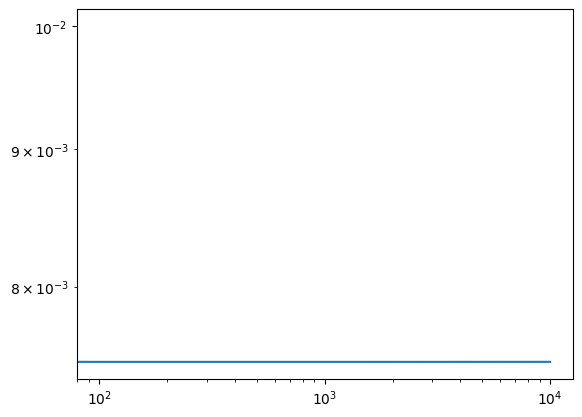

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


In [8]:
A_pre = torch.nn.Parameter(torch.eye(N))

def forward(params, W1):
    return params[0] @ W1

params = [A_pre]
exp(params, forward)

### Post Mult Full

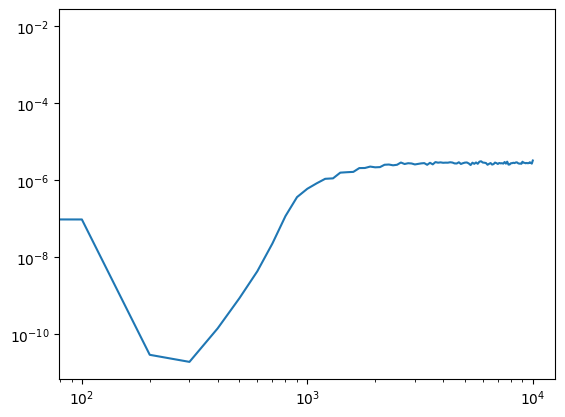

tensor(3.1827e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:
A_post = torch.nn.Parameter(torch.eye(M))

def forward(params, W1):
    return W1 @ params[0]

params = [A_post]
exp(params, forward)

### Mult Pre r

##### Rank 1#####
tensor(0.9883, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9715, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9390, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8784, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7685, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5799, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2976, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)


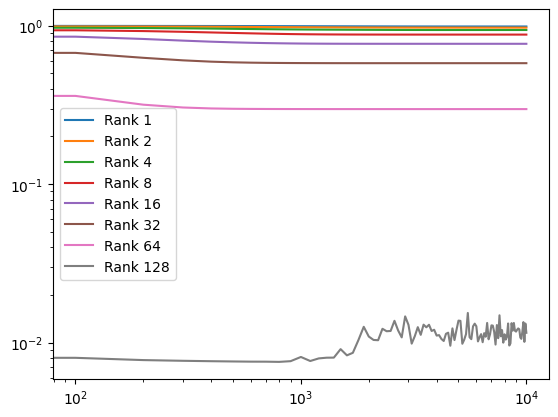

In [10]:
def forward(params, W1):
    return params[0] @ (params[1] @ W1)

def init(params):
    init_mult_lora_matrices(params[0], params[1])

set_shift_indices(N,N)
rank_exp([N,N], forward, init)

### Mult Post r

##### Rank 1#####
tensor(0.9882, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9714, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9387, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8779, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7676, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5780, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2939, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.5111e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(5.3756e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.4421, device='cuda:0', grad_fn=<MseLossBackward0>)


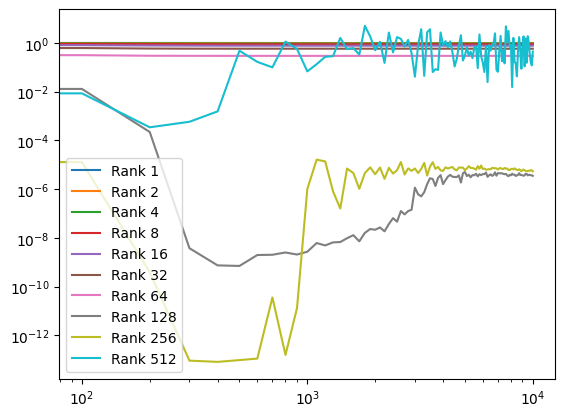

In [11]:
def forward(params, W1):
    return (W1 @ params[0]) @ params[1]

def init(params):
    init_mult_lora_matrices(params[0], params[1])

set_shift_indices(M,M)
rank_exp([M,M], forward, init)

### LoRA

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(8.2422e-15, device='cuda:0', grad_fn=<MseLossBackward0>)


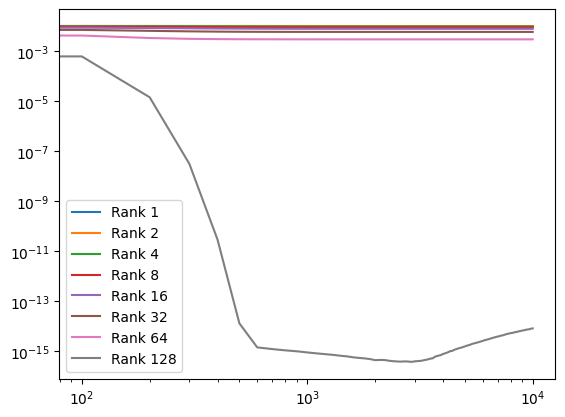

In [12]:
def forward(params, W1):
    return W1 + params[0] @ params[1]

def init(params):
    init_lora_matrices(params[0], params[1])

rank_exp([N,M], forward, init)

### LoRA - shift

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(8.3115e-15, device='cuda:0', grad_fn=<MseLossBackward0>)


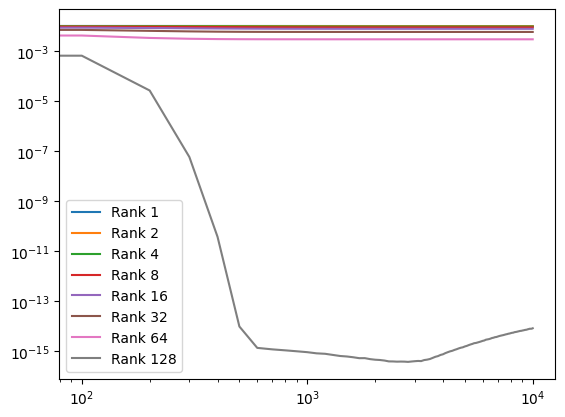

In [13]:
def forward(params, W1):
    return W1 + shift(params[0] @ params[1])

def init(params):
    init_lora_matrices(params[0], params[1])

set_shift_indices(N,M)
rank_exp([N,M], forward, init)

### Pre Mult r - shift

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


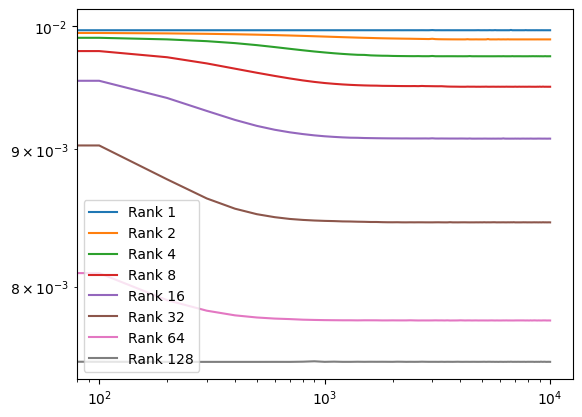

In [14]:
def forward(params, W1):
    return shift(params[0] @ params[1]) @ W1

def init(params):
    init_shift_lora_matrices(params[0], params[1])

set_shift_indices(N,N)
rank_exp([N,N], forward, init)

### Post Mult r - shift

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.5328e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.7094e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.9559e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(1.9116e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


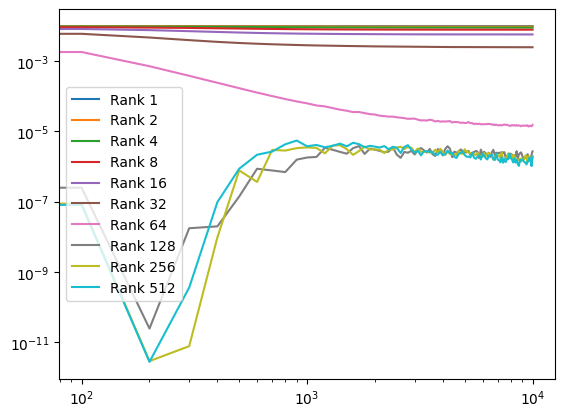

In [15]:
def forward(params, W1):
    return W1 @ shift(params[0] @ params[1])

def init(params):
    init_shift_lora_matrices(params[0], params[1])

set_shift_indices(M,M)
rank_exp([M,M], forward, init)